# Import required modules

In [2]:
# Import required modulesimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import random
import os
import torch
from matplotlib.pylab import MultipleLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")

In [3]:
# Instantiate regressor algorithms
GBR = GradientBoostingRegressor(random_state=42)
KNR = KNeighborsRegressor()
RFR = RandomForestRegressor(random_state=42)
SR = SVR()
KRR = KernelRidge()
xgbr = XGBRegressor(random_state=42)
light = LGBMRegressor(random_state=42)

In [4]:
# Read data
file_name='Feature_CO.xlsx'
df = pd.read_excel('../'+file_name, sheet_name= "ML_features")
features = df.iloc[:,:-1]
# delete high correlated features
features3 = features.drop(columns=['$\\mathregular{χ_{NM(0-3)}}$',
                                   '$\\mathregular{m_{NM(0-3)}}$',
                                   '$\\mathregular{r_{NM(3-4)}}$',
                                   '$\\mathregular{m_{NM(3-4)}}$',
                                   '$\\mathregular{χ_{NM(4-5)}}$',
                                   '$\\mathregular{r_{NM(4-5)}}$',
                                   '$\\mathregular{m_{M}}$',
                                    '$\\mathregular{χ_{M}}$',])
#redefine name 
features = features3
target = df.iloc[:,-1]

In [110]:
# Adding gaussian noise to target values to prevent overfitting
np.random.seed(1)
mu  =  0    # 高斯噪声的均值
sigma = 0.065  # 高斯噪声的方差, 1. 0.065; 2.0.1
# [1, 106], 106是数据的行数
noise = np.random.normal(mu, sigma, [1,108]).tolist()
target_2 = target + noise[0]
# target_2

# Feature normalization

In [111]:
# standardize the descriptor 
mean1 = features.mean(axis=0)                              ## 求平均， numpy中的功能 
std1 = features.std(axis=0)                                #  Z标准化：实现中心化和正态分布 
# comment this line if you want unstandardized descriptors  
features = (features - mean1)/ std1                             #  Z标准化：实现中心化和正态分布  
features

,$\mathregular{r_{NM(0-3)}}$,$\mathregular{χ_{NM(3-4)}}$,$\mathregular{m_{NM(4-5)}}$,$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$,$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$,$\mathregular{χ_{NM(4-5)}}$-$\mathregular{χ_{M}}$,Z,$\mathregular{r_{M}}$,$\mathregular{G_{M}}$,$\mathregular{e_{d}}$,I1,$\mathregular{ε_{d}}$,$\mathregular{H_{of}}$,$\mathregular{EA_{M}}$
0,-0.930357,0.384828,0.473761,1.494592,1.418959,1.440114,-1.224866,0.407483,-1.625343,-1.649608,-1.265485,1.606882,-1.004181,-0.856247
1,-0.930357,0.517517,0.127287,1.048054,0.943201,0.851483,-1.176498,-0.013648,-1.265636,-1.309613,-0.970301,1.287183,-1.228018,-1.031254
2,0.357122,0.882409,0.127287,0.419594,0.761063,0.611588,-1.128131,-0.276854,-0.905929,-0.969617,-1.061297,1.074050,-0.456494,-0.316774
3,0.357122,0.882409,0.127287,0.345171,0.677642,0.531623,-1.079763,-0.540061,-0.546222,-0.289626,-1.037993,0.587841,-0.006438,-0.088782
4,-0.930357,0.517517,0.127287,1.023247,0.915394,0.824828,-1.031395,-0.803267,-0.186515,-0.289626,-0.297814,0.015048,0.176918,-1.158094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.357122,0.882409,-1.258609,-0.250213,0.010267,-0.543463,1.386987,0.618048,-0.186515,-0.289626,0.197118,-0.231387,-0.642231,-0.917258
104,0.357122,0.882409,-1.258609,-0.994442,-0.823952,-1.343113,1.435355,0.460124,0.173192,0.050370,1.118180,-0.664313,0.007849,0.608037
105,0.357122,0.882409,-1.258609,-0.994442,-0.823952,-1.343113,1.483722,0.196917,0.532899,0.390365,1.573163,-1.143861,-0.065969,1.362656
106,0.357122,0.882409,-1.258609,-1.192903,-1.046410,-1.556353,1.532090,0.038994,0.892606,1.070356,1.462192,-0.790860,0.679361,2.258567


# Model performance for default parameters

In [1]:
#  data splitting  
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size= 0.8, random_state=42) 

# Define the model
model = GBR

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)

# model scores
mse_ads = [abs(s) for s in scores]
mse_tr = np.mean(mse_ads)

model.fit(X_train, y_train)
y_tr_pred = model.predict(X_train)

# print ('----------------- RMSE -----------------')
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print ('RMSE for training (v2): {:.4f} eV'.format(np.sqrt(mean_squared_error(y_tr_pred, y_train))))

R_squr_train = r2_score(y_train, y_tr_pred)
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

# model testing
y_te_pred = model.predict(X_test)


MAE = mean_absolute_error(y_te_pred, y_test)
MSE = mean_squared_error(y_te_pred, y_test)
RMSE = MSE**.5
print ('calcultae average RMSE for test {:.4f} eV'.format(RMSE))
R_squr = r2_score(y_test, y_te_pred)
print ('R^2 for test {:.4f} eV'.format(R_squr))



# Scatterplot of predicted versus actual values
font = {'size': '24'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='b', marker='o', label='Training')
ax.scatter(y_test, y_te_pred, alpha=0.5, c='r', marker='o', label='Test')

plt.xlim(-3, 0)
plt.ylim(-3, 0)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)

y_major_locator=MultipleLocator(0.5)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 


plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)

plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,fontsize=24)

plt.legend(loc=0)
plt.title('GBR')
# plt.savefig('Model_performance_default_para.jpg', dpi=600, bbox_inches='tight')
plt.show()

NameError: name 'train_test_split' is not defined

# Hyperparameter tuning 

In [123]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

model_grid = {'loss':['ls', 'lad', 'huber', 'quantile'],
             'n_estimators': [10,50,100],
             'learning_rate':[0.05, 0.1, 0.15],
             'max_depth':[2,3,4],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[1,2,4]}
model.get_params().keys()
from sklearn.model_selection import RandomizedSearchCV
model_grid_cv = RandomizedSearchCV(estimator=model,
                        param_distributions=model_grid,
                        n_iter=100,
                        cv=10,
                        verbose= True)
model_grid_cv.fit(X_train,y_train)

GradientBoostingRegressor(random_state=42)


dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [124]:
model_optimized = model_grid_cv.best_estimator_
print (model)
print (model_optimized)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [10, 50, 100]},
                   verbose=True)

#  Model performance after hyperparameter tuning

MSE for training: 0.2208 eV
RMSE for training: 0.4381 eV
R^2 for train 0.9425 eV
y_te_pred: 
 [-2.79525807 -1.03932528 -1.10485993 -1.35677658 -1.5439743  -1.60095402
 -0.57674453 -0.50648676 -2.29786278 -2.01445932 -1.22031616 -2.36921408
 -1.32912295 -2.62260484 -0.42537027 -1.90201443 -1.15473482 -2.06936565
 -2.16623569 -1.52212269 -2.25875148 -0.65997501]
calcultae average MAE for test: 0.0659 eV
calcultae average MSE for test: 0.00754887 eV
calcultae average RMSE for test 0.0869 eV
R^2 for test 0.9853 eV


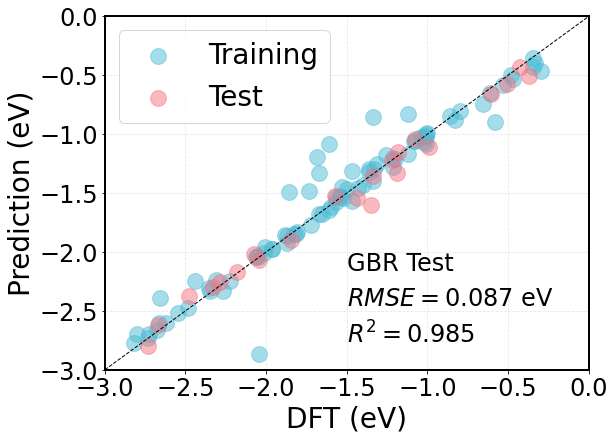

In [131]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size= 0.8, random_state=42) 


kfold = KFold(n_splits=10, shuffle=False)
scores = cross_val_score(model_optimized, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)

# model scores
mse_ads = [abs(s) for s in scores]
mse_tr = np.mean(mse_ads)

# predicted value for y_train
y_tr_pred = model_optimized.predict(X_train)

# print ('----------------- RMSE -----------------')
rmse_scores = np.sqrt(mean_squared_error(y_tr_pred, y_train))
R_squr_train = r2_score(y_train, y_tr_pred)

print ('RMSE for training (v2): {:.4f} eV'.format(rmse_scores))
print ('R^2 for train {:.4f} eV'.format(R_squr_train))


# predicted value for y_test
y_te_pred = model_optimized.predict(X_test)
MAE = mean_absolute_error(y_te_pred, y_test)
MSE = mean_squared_error(y_te_pred, y_test)
RMSE = MSE**.5
R_squr = r2_score(y_test, y_te_pred)
print ('calcultae average RMSE for test {:.4f} eV'.format(RMSE))
print ('R^2 for test {:.4f} eV'.format(R_squr))


# Scatterplot of predicted versus actual values
font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='#4DBBD5', marker='o', label='Training', s=250)
ax.scatter(y_test, y_te_pred, alpha=0.5, c='#f67280', marker='o', label='Test', s=250)

plt.xlim(-3, 0)
plt.ylim(-3, 0)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)


y_major_locator=MultipleLocator(0.5)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 


plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)


plt.text(0.5, 0.3, 'GBR Test', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,fontsize=24)

plt.legend(loc=0)
# plt.title('GBR')
# plt.savefig('Model_performance_opt_para.jpg', dpi=600, bbox_inches='tight')
plt.show()

# MAE

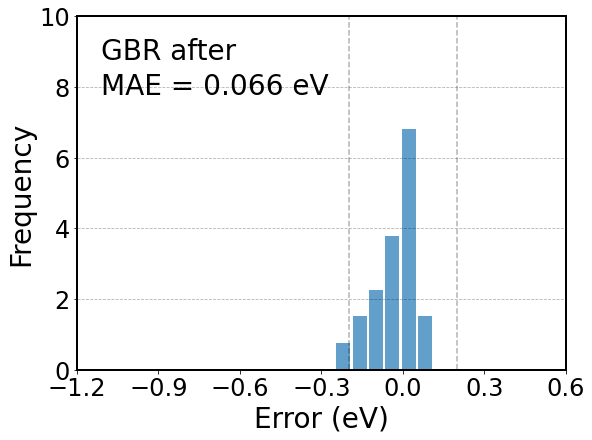

In [132]:
error1 = y_te_pred - y_test

def relative_error(y_te_pred, y_test):
    relative_error = np.abs(y_te_pred - y_test)
    return relative_error
relative_error = relative_error(y_te_pred, y_test)

MAE = mean_absolute_error(y_te_pred, y_test)



font={'weight':'normal', 'size': 28}

fig, ax = plt.subplots(figsize=(8.76, 6.5))
n, bins, patches = plt.hist(x=error1, bins='auto', alpha=0.7, rwidth=0.85, density=True)


plt.xlabel('Error (eV)', fontsize=28)
plt.ylabel('Frequency', fontsize=28)

plt.xlim(-1.2, 0.6)
plt.ylim(0, 10)
ax.xaxis.set_major_locator(MultipleLocator(0.3))

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.grid(axis='y',ls='--',  c='black', alpha=0.3)

plt.text(0.05, 0.9, 'GBR after', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=28)
plt.text(0.05, 0.8, 'MAE = %0.3f eV'% MAE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,  fontsize=28)

# ax.plot([-5, 5], [2, 2], linestyle='--', c='black', alpha=0.3)
# ax.plot([-5, 5], [4, 4], linestyle='--', c='black', alpha=0.3)
# ax.plot([-5, 5], [6, 6], linestyle='--', c='black', alpha=0.3)
# ax.plot([-5, 5], [8, 8], linestyle='--', c='black', alpha=0.3)
# ax.plot([-5, 5], [10, 10], linestyle='--', c='black', alpha=0.3)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 


ax.plot([-0.2, -0.2], [-100, 100], linestyle='--', c='black', alpha=0.3)
ax.plot([0.2, 0.2], [-100, 100], linestyle='--', c='black', alpha=0.3)

# plt.savefig('MAE error frequency.jpg', dpi=600, bbox_inches='tight')
plt.show()

# 数据分布

Setup Complete


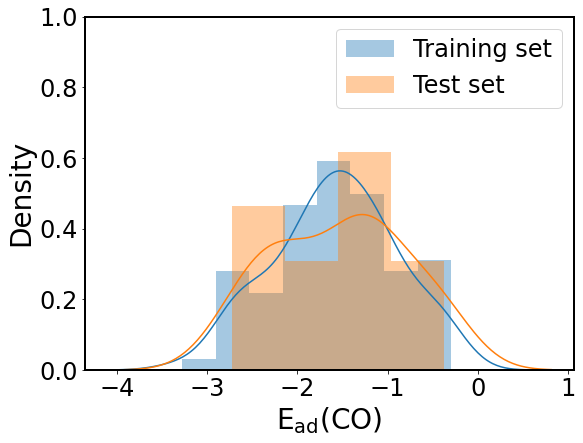

In [135]:
pd.plotting.register_matplotlib_converters()
print("Setup Complete")

fig, ax = plt.subplots(figsize=(8.76, 6.5))

sns.distplot(a=y_train, kde=True, label='Training set')
sns.distplot(a=y_test, kde=True,label='Test set')

plt.legend(loc=0, fontsize=24)
plt.ylim(0,1)


plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 

# plt.title('Distribution of $\mathregular{E_{ad}(CO)}$')
# plt.savefig("Distribution of Ead_CO-2.jpg", dpi=600, bbox_inches='tight')

# Visualization of decision trees

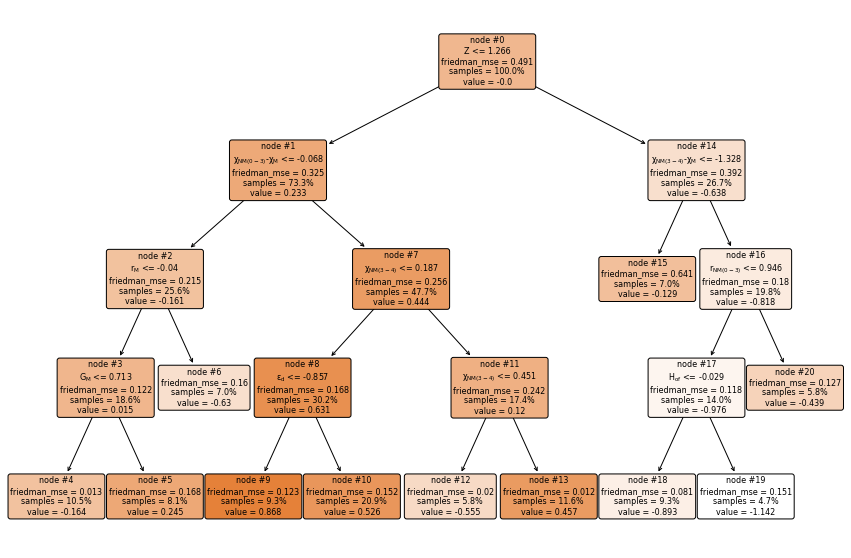

In [149]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import graphviz

# headers
headers = features.columns.values.tolist()

# assume X_train and y_train are your training data
model_optimized
font = {'size':20}
plt.rc("font", **font)

# get the first decision tree in the ensemble
first_tree = model_optimized.estimators_[0][0]

# get the leaf node indices of the tree
leaf_node_indices = first_tree.apply(X_train)


# plot the decision tree
plt.figure(figsize=(15,10))
    
plot_tree(first_tree, feature_names=X_train.columns, filled=True, impurity=True, proportion=True, rounded=True,
           node_ids=True, fontsize=8)  # Change the color to 'green' for all nodes, including leaf nodes

# Get the leaves' index from the tree
leaves = first_tree.apply(X_train) == -1

# Get the matplotlib Patch objects representing the nodes in the tree plot
patches = plt.gca().patches

# Set the face color of the leaf nodes to green
for node_id, patch in enumerate(patches):
    if leaves[node_id]:
        patch.set_facecolor('red')
        
# plt.title('GBR model')
# plt.savefig('tree_0.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Pearson coeff 

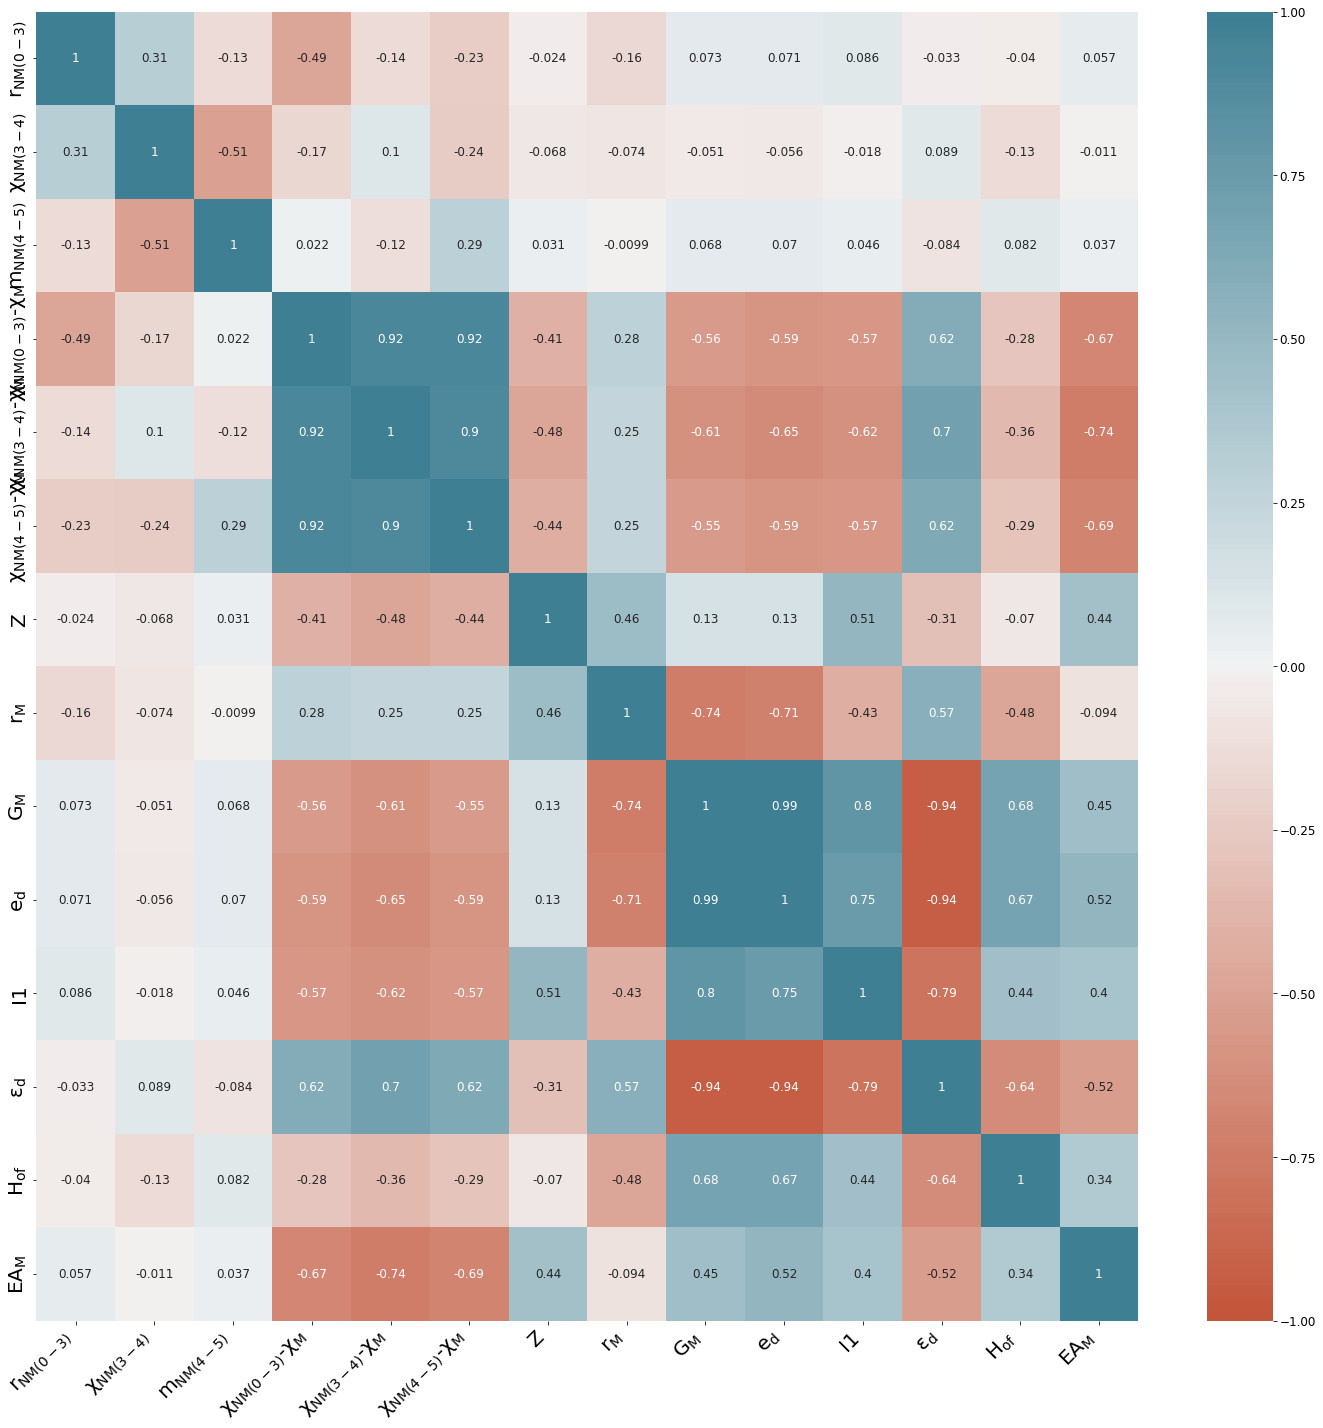

In [159]:
font = {'size':12}
plt.rc('font', **font)

coeff = features

# data = df.iloc[:, :-1]
# # print (data)
# corr = data.corr()
# print (corr)
corr = coeff.corr()
ax = sns.heatmap(corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=220),annot=True)

ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right',rotation=45,size=20)
ax.set_yticklabels(ax.get_xticklabels(),horizontalalignment='right',size=20)

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout()

# fig = ax.get_figure()
# fig.savefig('Pearson.jpeg', dpi=600,)

# Histogram of feature importance

In [160]:
headers = features.columns.values.tolist()
headers[0]
len(headers)
# headers
headers

['$\\mathregular{r_{NM(0-3)}}$',
 '$\\mathregular{χ_{NM(3-4)}}$',
 '$\\mathregular{m_{NM(4-5)}}$',
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$',
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$',
 '$\\mathregular{χ_{NM(4-5)}}$-$\\mathregular{χ_{M}}$',
 'Z',
 '$\\mathregular{r_{M}}$',
 '$\\mathregular{G_{M}}$',
 '$\\mathregular{e_{d}}$',
 'I1',
 '$\\mathregular{ε_{d}}$',
 '$\\mathregular{H_{of}}$',
 '$\\mathregular{EA_{M}}$']

In [162]:
#  color list
colors = [ 
'#99CCFF',  '#99FF99', 
'#CCCC00', '#CC99FF', '#8FCD13', '#FF99CC', '#4F9186',
'#c86b85', '#878ecd', '#a8e6cf',  '#3f72af', '#f08a5d', 
'#ffde7d',  '#f67280', '#307672', '#fbac91', '#d4a5a5',
'#769fcd',  '#30e3ca', '#FCBAD3', '#aa96da', '#4DBBD5', ]

colors = [ 
  '#878ecd', '#a8e6cf',  '#3f72af', '#f08a5d', 
'#ffde7d',  '#f67280', '#307672', '#fbac91', '#d4a5a5',
'#769fcd',  '#30e3ca', '#FCBAD3', '#aa96da', '#4DBBD5', ]

14
[0.01283427 0.01384838 0.02057628 0.02234662 0.0280536  0.03173012
 0.03461492 0.05318644 0.05562735 0.06777241 0.10313573 0.10814647
 0.15221908 0.29590833]
['$\\mathregular{G_{M}}$' 'I1' '$\\mathregular{H_{of}}$'
 '$\\mathregular{e_{d}}$'
 '$\\mathregular{χ_{NM(4-5)}}$-$\\mathregular{χ_{M}}$'
 '$\\mathregular{r_{NM(0-3)}}$' '$\\mathregular{ε_{d}}$'
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$'
 '$\\mathregular{EA_{M}}$' '$\\mathregular{m_{NM(4-5)}}$'
 '$\\mathregular{r_{M}}$' '$\\mathregular{χ_{NM(3-4)}}$'
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$' 'Z']


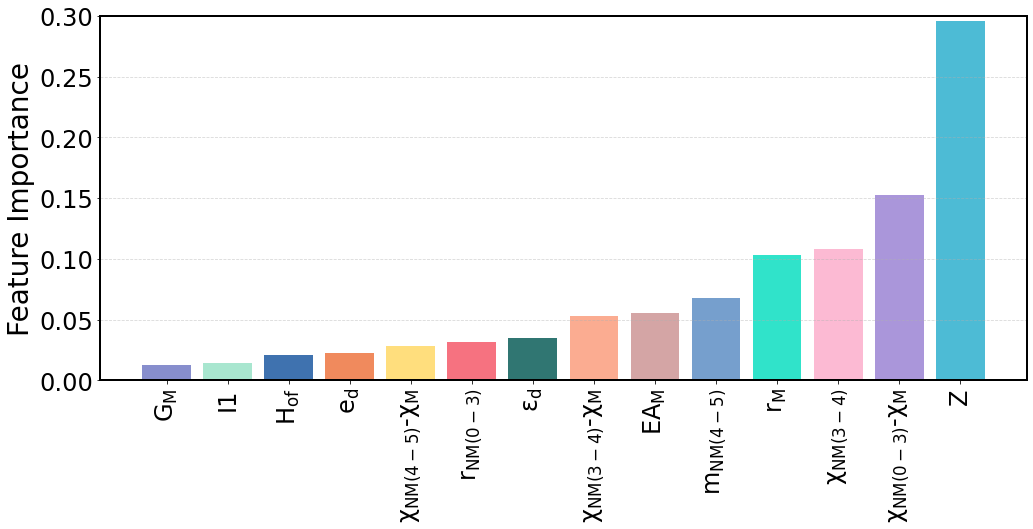

In [163]:
importances = model_optimized.feature_importances_
headers = headers 
print (len(headers))

sorted_idx = np.argsort(importances)
sorted_idx

importances_2 = importances[sorted_idx]
print (importances_2)

headers_2 = np.array(headers)[sorted_idx]
# headers = headers[len(headers)]
print (headers_2)

fig, ax = plt.subplots( figsize=(15, 8))


font={'weight':'normal', 
      'size': 28}
plt.rc('font', **font)


# ax.barh(importances_2,
#         headers_2,
#         height=0.7)

plt.bar(headers_2, importances_2, color=colors)

# ax.set_xlabel("Feature Importance", fontsize = 28)
ax.set_ylabel("Feature Importance", fontsize = 28)
ax.tick_params(axis='y', )
ax.tick_params(axis='x', rotation = 90)

plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 
# plt.title('GBR feature importance')
# plt.title('$\mathregular{χ_{NM}}$(4-5)-χ_M')
plt.grid(axis='y', ls='--', alpha=0.5)


ax.set_ylim(0, 0.30)

plt.tight_layout()
# fig.savefig('Feature importance_all-heng.jpeg', dpi=600,)

# Pie chart of feature importance

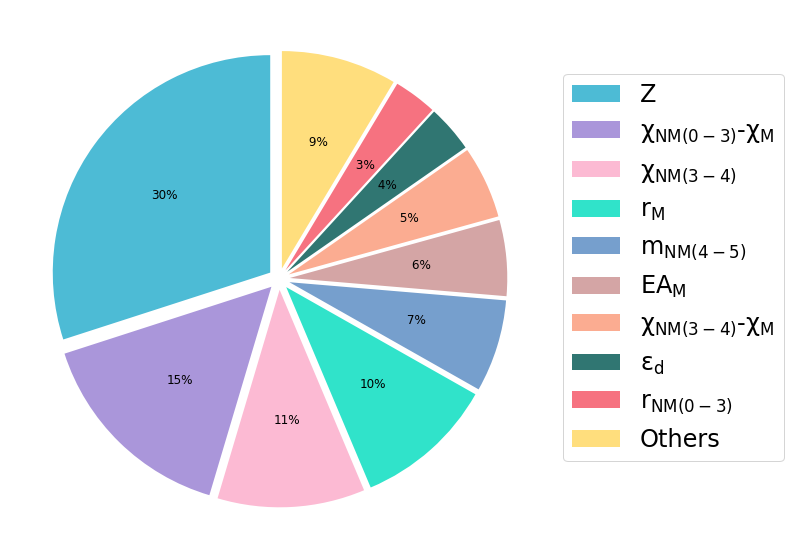

In [164]:
# 特征重要性饼状图

# 默认是从小到大的排序
sorted_idx = np.argsort(importances)
sorted_idx

# sort 排序得到的 index， 而不是具体的数
importances_2 = importances[sorted_idx]
importances_2

# pie
feature_numbers = 13
idx_third_tem = model_optimized.feature_importances_.argsort()   # 对特征重要性排序  
idx_third = idx_third_tem[-feature_numbers]          # 测试一下， 最后一个是多少

# 得到从大到小的index
feature_idx = (-model_optimized.feature_importances_).argsort()[:feature_numbers] 

feature_idx

# 对importance 加负号，然后排序，得到的index就是 从大到小的
(-model_optimized.feature_importances_) 

(-model_optimized.feature_importances_).argsort()

# 得到特征的名字
name_features = np.array(headers)[feature_idx]  
name_features

(-model_optimized.feature_importances_).argsort()[:feature_numbers] 

# 特征重要性的具体的数据
selected_features = model_optimized.feature_importances_[feature_idx]
selected_features


# 只画前 n 个重要的特征，而将其他的合并为others
font={'weight':'normal', 'size': 12}

cmap = plt.get_cmap("tab20")

colors = cmap(np.arange(len(headers)))

labels= name_features  ## np.array(headers)[tree_importance_sorted_idx[3:]]
sizes= selected_features

#  不同块之间的分割
myexplode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05,]

fig, ax = plt.subplots(figsize=(15, 10))

top_sizes = sizes[:9]
top_labels = labels[:9]

other_label = 'Others'
other_size = sum(sizes[9:])

labels_to_plot = np.append(top_labels, [other_label])
labels_to_plot

sizes_to_plot = np.append(top_sizes, [other_size])
sizes_to_plot


wedges,texts, autotexts = plt.pie(sizes_to_plot, 
#                                    colors=colors[:11], 
                                  colors=['#4DBBD5', '#aa96da','#FCBAD3','#30e3ca','#769fcd', 
                                           '#d4a5a5','#fbac91','#307672',  '#f67280',  '#ffde7d', ],
                                   explode = myexplode[:10], 
                                   startangle=90, 
                                   textprops=font,
                                  autopct='%2.f%%', )

ax.legend(labels_to_plot, bbox_to_anchor=(1, 0, 0, 0.9), fontsize=24, ncol=1)

# plt.setp(ax.texts, size=12)
# plt.setp([t for t in ax.texts if '%' in t.get_text()], ha='center', va='center')

# plt.title('GBR feature importance', fontsize=28)
# fig.savefig('Feature importance.jpg', dpi=600, bbox_inches='tight')
plt.show()

# standard SHAP values

In [152]:
import shap
# 假设 model_optimized 是您训练好的GBR模型
explainer = shap.Explainer(model_optimized)
shap_values = explainer.shap_values(features)
# shap_values.values

In [153]:
np.shape(shap_values)

(22, 14)

In [154]:
shap_values[0:10]

array([[-2.98556798e-02,  1.05754459e-01,  6.65485483e-02,
         2.74714501e-01, -2.22753834e-02,  1.05918094e-01,
         2.51623839e-01,  2.19097795e-01, -1.37298904e-02,
        -1.13727162e-02,  1.78012953e-02,  4.97757064e-02,
        -1.41527143e-02,  3.24251626e-02],
       [-1.39503863e-02, -1.38815803e-01, -1.09239135e-02,
        -1.85573469e-01, -2.55692580e-02, -3.96491326e-02,
         1.90758299e-01,  1.22037325e-01, -2.23293462e-02,
        -1.15777475e-02, -9.67147279e-03,  2.78725507e-02,
        -1.03562845e-02,  3.50131110e-02],
       [-9.14790688e-02, -2.26240626e-01,  2.86265068e-02,
        -2.03377575e-02, -3.96303703e-02, -3.86309006e-02,
         2.03277523e-02, -1.66470873e-01, -1.61948198e-02,
        -9.93948133e-05, -1.60139157e-02,  5.64493526e-03,
        -5.78376905e-02, -9.98305203e-02],
       [-4.00275386e-02,  1.99784502e-01, -7.04398107e-02,
         1.28677783e-01,  1.70391832e-02,  6.34142271e-02,
         1.80319464e-01, -9.52653324e-02, -1.

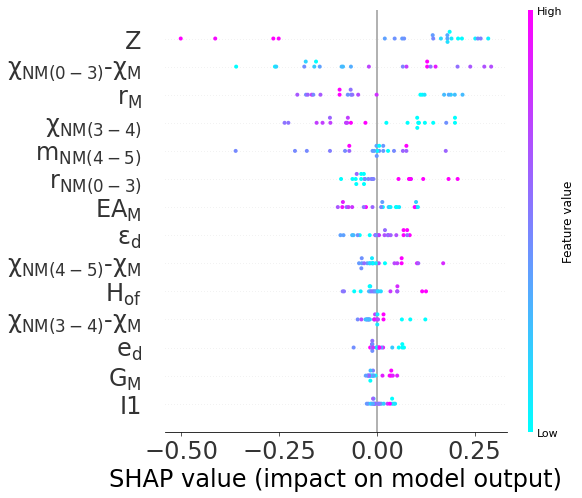

In [158]:
# 修改图片格式
# fig, ax = plt.subplots(figsize=(8.76, 6.5))  

font={'size': 24}
plt.rc('font', **font)

plt.figure(figsize=(8.75,6.5))
shap.summary_plot(shap_values, features,  show=False, cmap='cool', )

plt.tick_params(labelsize=24)
plt.xlabel('SHAP value (impact on model output)', fontsize=24)
# plt.savefig('./figures/SHAP_图片2.jpeg', dpi=600, bbox_inches='tight' )
plt.show()

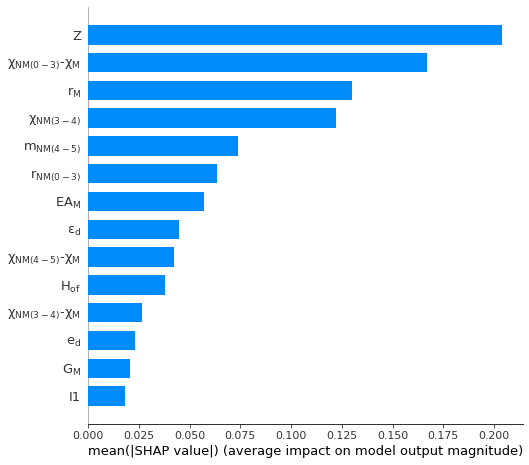

In [206]:
import matplotlib.pyplot as plt

font={'size': 28}
plt.rc('font', **font)

# fig, ax = plt.subplots(figsize=(8.76, 6.5)) 

plt.figure(figsize=(8.75,6.5))
shap.summary_plot(shap_values, X_test,  show=False, 
                 plot_type="bar",)
# plt.savefig('./SHAP feature importance.jpeg', dpi=600, bbox_inches='tight' )
plt.show()

# PDP 

feature_names Index(['$\mathregular{r_{NM(0-3)}}$', '$\mathregular{χ_{NM(3-4)}}$',
       '$\mathregular{m_{NM(4-5)}}$',
       '$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(4-5)}}$-$\mathregular{χ_{M}}$', 'Z',
       '$\mathregular{r_{M}}$', '$\mathregular{G_{M}}$',
       '$\mathregular{e_{d}}$', 'I1', '$\mathregular{ε_{d}}$',
       '$\mathregular{H_{of}}$', '$\mathregular{EA_{M}}$'],
      dtype='object')
0
features [(0,)]


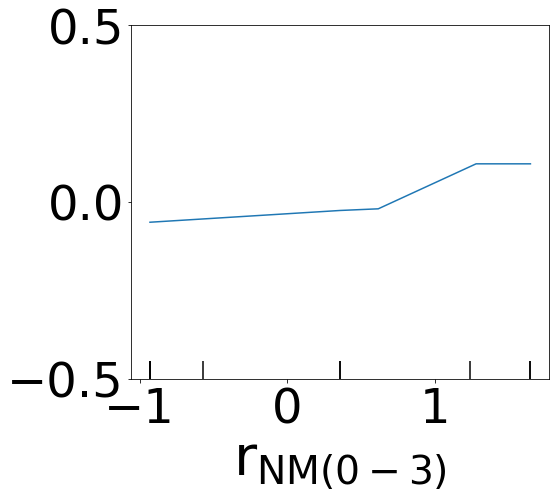

1
features [(1,)]


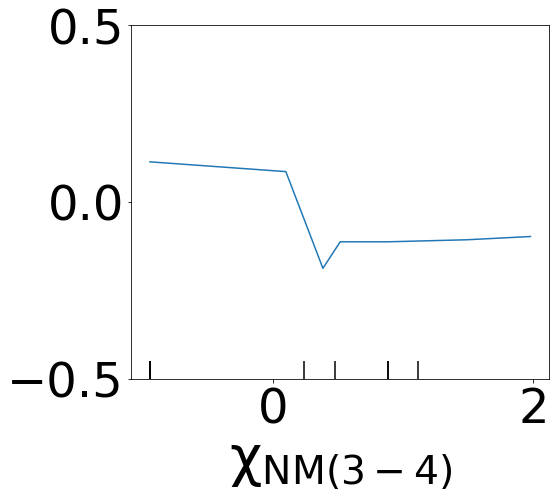

2
features [(2,)]


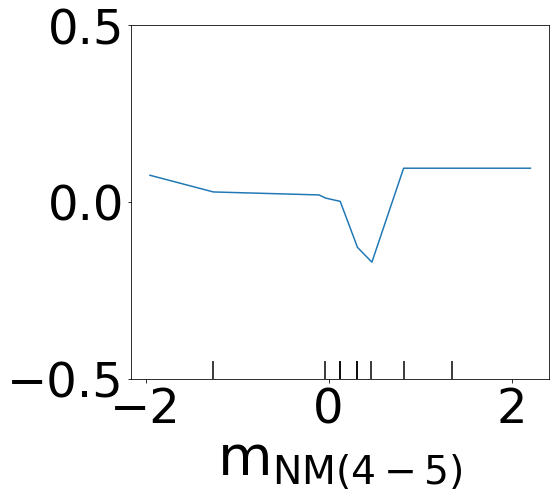

3
features [(3,)]


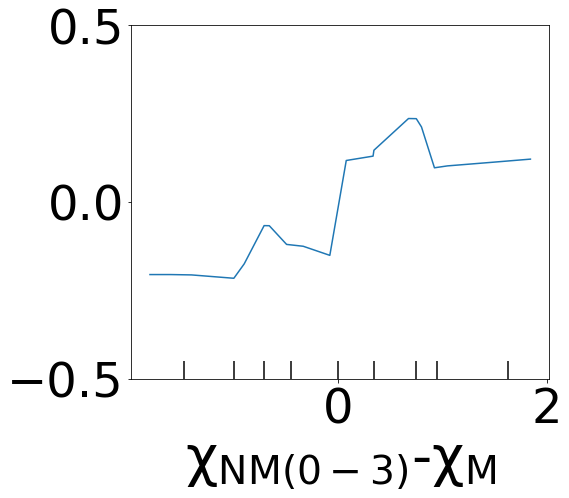

4
features [(4,)]


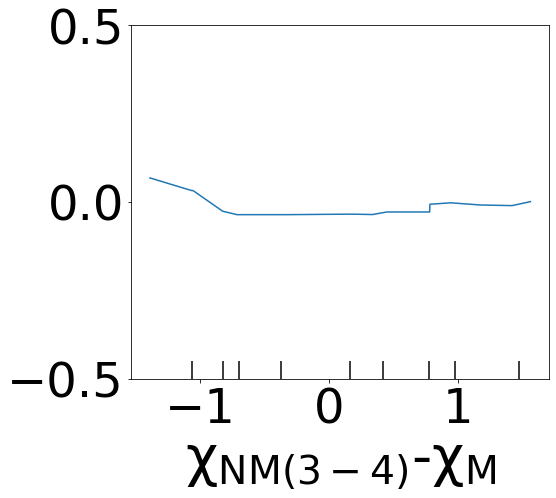

5
features [(5,)]


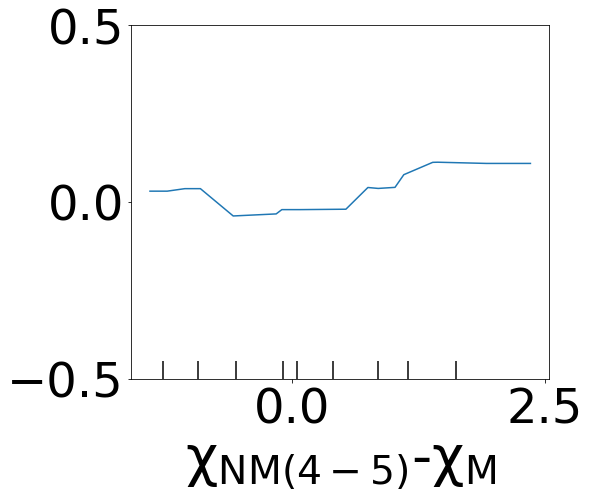

6
features [(6,)]


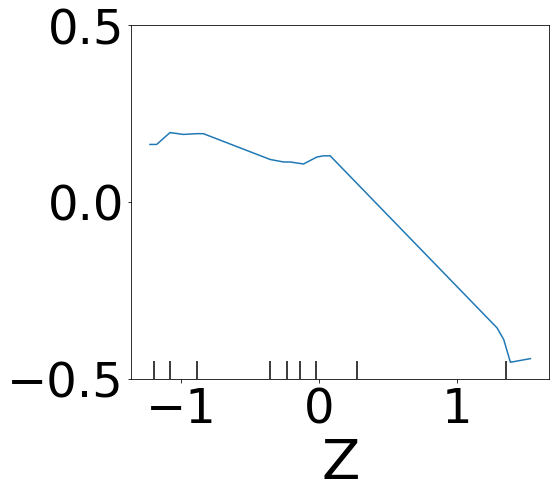

7
features [(7,)]


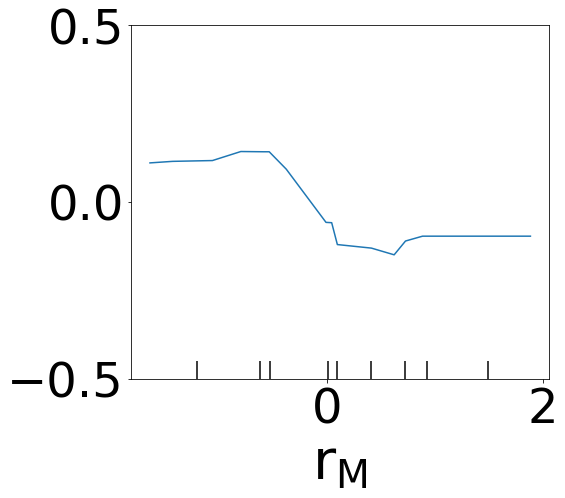

8
features [(8,)]


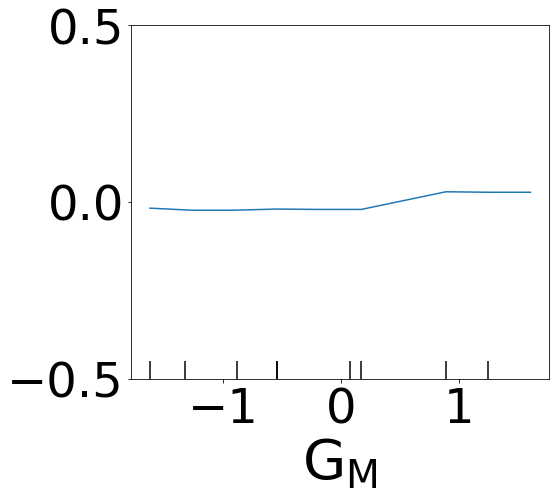

9
features [(9,)]


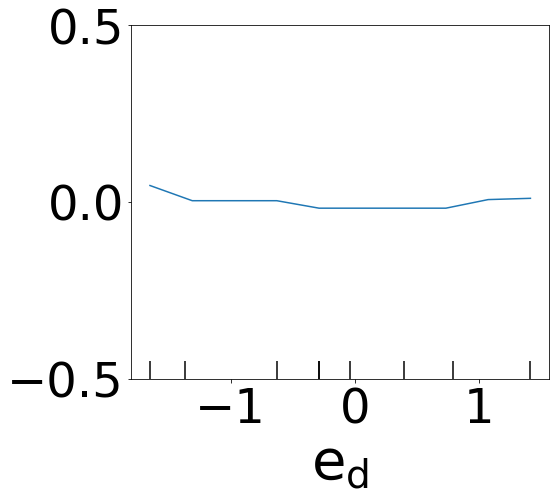

10
features [(10,)]


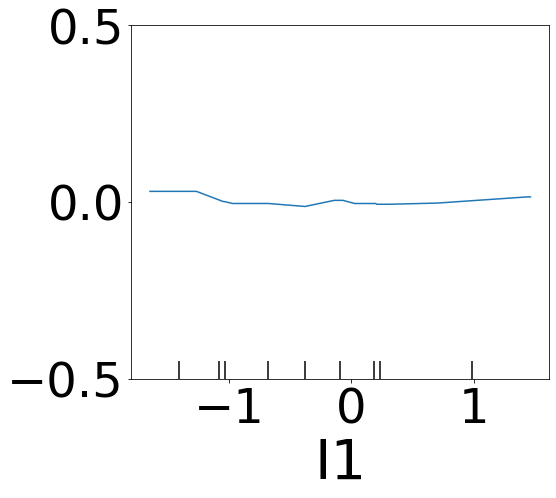

11
features [(11,)]


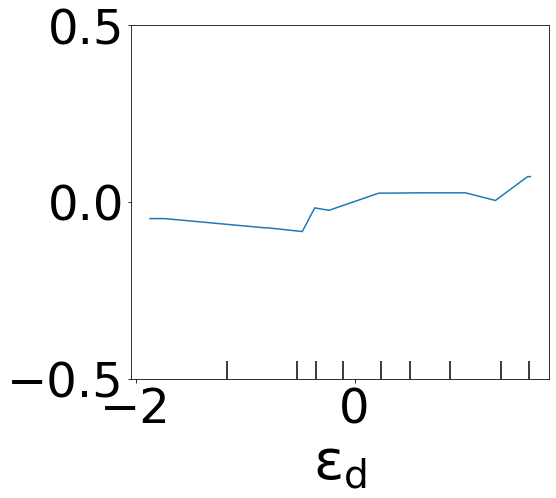

12
features [(12,)]


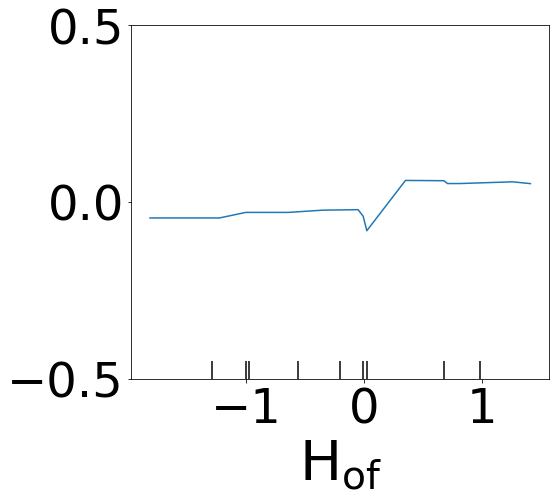

In [208]:
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay


# 设置字体大小
font = {'size':'56'}
plt.rc ('font', **font)

clf = model_optimized
feature_names = X_test.columns
print ('feature_names', feature_names)

# feature_of_interest = feature_names[feature_index]

# 所有的features
# feature_names
# X_test.shape[1] 指的是特征的个数

# for i in 
for i in range(13):
    print (i)
    number=i
    features, feature_names = [(number,)], [f"Features #{i}" for i in range(X_test.shape[1])]
    features
    fig, ax = plt.subplots(figsize=(7.5, 6.5)) 
    PartialDependenceDisplay.from_estimator(clf, X_test, features,  ax=ax )
    plt.ylim(-0.5, 0.5)
    print ('features', features)
    
    ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
    ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
    ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
    ax.spines['top'].set_linewidth(2);   ####设置上部坐标轴的粗细
    plt.tick_params(labelsize=48)
    
    # plt.xlabel('SHAP value', fontsize=28)

    plt.ylabel("")
#     plt.savefig(f'./figures/PDP-{number}.jpeg', dpi=600, bbox_inches='tight' )
    plt.show()

In [166]:
X_test.iloc[sample_index]

$\mathregular{r_{NM(0-3)}}$                         -0.930357
$\mathregular{χ_{NM(3-4)}}$                         -0.942055
$\mathregular{m_{NM(4-5)}}$                          0.820235
$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$    0.750363
$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$    0.337002
$\mathregular{χ_{NM(4-5)}}$-$\mathregular{χ_{M}}$    0.749305
Z                                                   -1.079763
$\mathregular{r_{M}}$                               -0.540061
$\mathregular{G_{M}}$                               -0.546222
$\mathregular{e_{d}}$                               -0.289626
I1                                                  -1.037993
$\mathregular{ε_{d}}$                                0.587841
$\mathregular{H_{of}}$                              -0.006438
$\mathregular{EA_{M}}$                              -0.088782
Name: 30, dtype: float64

In [167]:
feature_names=X_test.columns
feature_names

Index(['$\mathregular{r_{NM(0-3)}}$', '$\mathregular{χ_{NM(3-4)}}$',
       '$\mathregular{m_{NM(4-5)}}$',
       '$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(4-5)}}$-$\mathregular{χ_{M}}$', 'Z',
       '$\mathregular{r_{M}}$', '$\mathregular{G_{M}}$',
       '$\mathregular{e_{d}}$', 'I1', '$\mathregular{ε_{d}}$',
       '$\mathregular{H_{of}}$', '$\mathregular{EA_{M}}$'],
      dtype='object')

In [178]:
feature_names = X_test.columns
print ('feature_names', feature_names)

feature_names Index(['$\mathregular{r_{NM(0-3)}}$', '$\mathregular{χ_{NM(3-4)}}$',
       '$\mathregular{m_{NM(4-5)}}$',
       '$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$',
       '$\mathregular{χ_{NM(4-5)}}$-$\mathregular{χ_{M}}$', 'Z',
       '$\mathregular{r_{M}}$', '$\mathregular{G_{M}}$',
       '$\mathregular{e_{d}}$', 'I1', '$\mathregular{ε_{d}}$',
       '$\mathregular{H_{of}}$', '$\mathregular{EA_{M}}$'],
      dtype='object')


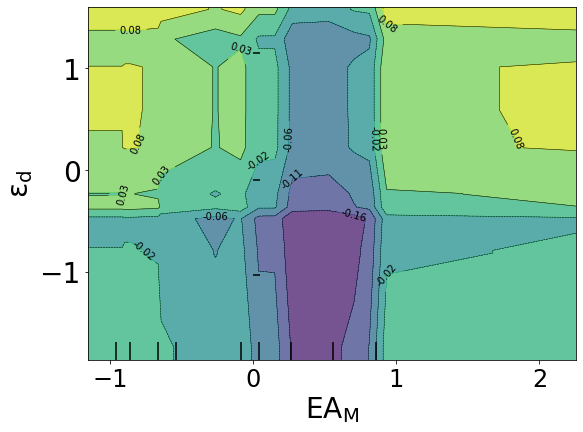

In [179]:
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# Set the font size

# Create subplots with 1 row and 2 columns

fig, ax = plt.subplots(figsize=(8.76, 6.5)) 
font = {'size': '28'}
plt.rc('font', **font)


clf = model_optimized
feature_names = X_test.columns

number=(13, 11)

# Second subplot
# Select the features for the second subplot
selected_features_2 = [ number ]  # Replace this with the indices of the features for the second subplot
# Create the PartialDependenceDisplay object for the second subplot
display_2 = PartialDependenceDisplay.from_estimator(clf, X_test, selected_features_2, ax=ax)

plt.xticks(fontsize=24)
# plt.savefig(f'./figures/PDP-2D-{number}.jpeg', dpi=600, bbox_inches='tight' )
plt.show()